Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

Path

In [2]:
output_folder = "data/weibo_preprocessed/"

uidlist.txt, repost_idlist.txt

In [3]:
u_to_userids = pd.read_csv("data/weibo/weibodata/diffusion/uidlist.txt",header=None)
u_to_userids.columns = ['userid']
u_to_userids.index.name = 'uid'

cascade_to_mids = pd.read_csv("data/weibo/weibodata/diffusion/repost_idlist.txt", header=None,)
cascade_to_mids.columns = ['mid']
cascade_to_mids.index.name = 'cascade'
cascade_to_mids.mid = cascade_to_mids.mid.astype(np.int64)

print("u_to_userids : \n" + u_to_userids.head(2).to_markdown())
print(f"shape : {u_to_userids.shape}\n")
print("cascade_to_mids : \n" + cascade_to_mids.head(2).to_markdown())
print(f"shape : {cascade_to_mids.shape}\n")

u_to_userids : 
|   uid |   userid |
|------:|---------:|
|     0 |    10029 |
|     1 |    10057 |
shape : (1787443, 1)

cascade_to_mids : 
|   cascade |         mid |
|----------:|------------:|
|         0 | 3.50952e+15 |
|         1 | 3.49137e+15 |
shape : (300000, 1)



userProfile

Extract : 

     id
     bi_followers_count
     city
     verified
     followers_count
     location
     province
     friends_count
     name
     gender
     created_at
     verified_type
     statuses_count
     description
    
     1657151084
     0
     5
     False
     33
     �Ϻ� ������
     31
     162
     JACKJONES
     m
     2009-10-29-22:20:41
     -1
     0

In [4]:
"""
creates the dataframe of user data and saves it in userProfile.pkl
"""
def convert_userProfile(save) : 
    
    df = [[] for _ in range(15)]
    with open("data/weibo/weibodata/userProfile/user_profile1.txt", mode='r', encoding='gbk') as file : 
        c = 0
        for line in file : 
            if c >= 15 : #not adding the first 15 lines : headers
                df[c%15].append(line.replace('\n',''))
            c += 1
    
    with open("data/weibo/weibodata/userProfile/user_profile2.txt", mode='r', encoding='gbk') as file : 
        c = 0
        for line in file : 
            if c >= 15 :
                df[c%15].append(line.replace('\n',''))
            c += 1
    d = {}
    for i in range(14) :
        d[i] = df[i]
    df = pd.DataFrame.from_dict(d, orient='columns')
    df.columns = ['uid', 'bi_followers_count', 'city', 
                 'verified', 'followers_count', 'location', 
                 'province', 'friends_count', 'name', 
                 'gender', 'created_at', 'verified_type', 
                 'statuses_count', 'description']
    df = df.astype({    'uid':np.int64, 
                        'bi_followers_count':np.int32, 
                        'city':'category', 
                        'verified':'category', 
                        'followers_count':np.int32, 
                        'province':'category', 
                        'friends_count':np.int32, 
                        'gender':'category', 
                        'verified_type':'category', 
                        'statuses_count': np.int32})
    print(f"\nuser_profile : \n{df.dtypes}")
    print(f"shape : {df.shape}\n")
    
    if save : 
        df.to_pickle(output_folder + "userProfile.pkl")
    return df
    
df = convert_userProfile(True)

#user_profile = pd.read_pickle(output_folder + "userProfile.pkl")


user_profile : 
uid                      int64
bi_followers_count       int32
city                  category
verified              category
followers_count          int32
location                object
province              category
friends_count            int32
name                    object
gender                category
created_at              object
verified_type         category
statuses_count           int32
description             object
dtype: object
shape : (1681085, 14)



### total.txt

extract : 

    3479380645050771 2012-08-15-20:07:32 1500872 3
    1500872 2012-08-15-20:41:02 1500872 2012-08-15-20:41:20
    3464585309142627 2012-07-06-00:16:10 153602 595
    1598909 2012-07-06-00:17:29 1727898 2012-07-06-00:24:20 1460582 2012-07-06-00:25:07

create infos_cascades/user_cascades

In [4]:
def extract_info_cascades(save = False) :
    """
    creates 2 files with information about all the cascades : 
        - infos_cascades : 
            i:n_cascades - mid(int64) - date(pd.DateTime) - u(int32) - n_likes(int32) - n_reposts(int32) - users2(list(int32))
        - user_cascades : 
            i:v(int32) - mids(list(int64)) - Av(int32)

    """

    d_user_cascade = defaultdict(lambda : [[]]) # d_user_cascade[userid] = list of cascades in which user appears
    infos_cascades = []

    with open("data/weibo/weibodata/total.txt", 'r') as file :
        count_line = 0 
        mid_cascade = None

        for line in file:
        
            if count_line % 60000 == 0 : print(f"{count_line//2000}K cascades processed")
        
            if count_line%2 == 0 : #mid - date - user1 - #likes
                mid_cascade = np.int64(line.replace('\n', '').split()[0])
                infos_cascades.append(line.replace('\n', '').split())
        
            else : # (uid timestamp )*
                curr_cascade = line.replace('\n', '').split()
                users2 = []
                for i in range(0, len(curr_cascade), 2) :
                    u = np.int32(curr_cascade[i])
                    d_user_cascade[u][0].append(mid_cascade)
                    users2.append(u)
                    
                infos_cascades[-1].append(len(curr_cascade)//2) #adds the number of reposts
                infos_cascades[-1].append(users2) 
                
            count_line+= 1
    print(f"{count_line//2000}K cascades processed")
    user_cascades = pd.DataFrame.from_dict(d_user_cascade, orient='index', columns = ['mids'])
    user_cascades['#cascades'] = user_cascades.mids.apply(len)
    
    print(f"\nuser_cascades : \n{user_cascades.dtypes}")
    print(f"shape : {user_cascades.shape}\n")
    
    infos_cascades = pd.DataFrame(infos_cascades, columns = ['mid', 'date', 'User1', '#likes', '#reposts', 'users2'],)
    infos_cascades = infos_cascades.astype(dtype={'mid' : np.int64, 'User1' : np.int32, '#likes' : np.int32, '#reposts' : np.int32})
    infos_cascades['date'] = pd.to_datetime(infos_cascades.date)

    print(f"\ninfos_cascades : \n{infos_cascades.dtypes}" )
    print(f"shape : {infos_cascades.shape}\n")

    if save:
        user_cascades.to_pickle(output_folder + "user_cascades.pkl")
        infos_cascades.to_pickle(output_folder + "infos_cascades.pkl")

    return user_cascades, infos_cascades

#user_cascades, infos_cascades = extract_info_cascades(True)

user_cascades = pd.read_pickle(output_folder + "user_cascades.pkl")
infos_cascades = pd.read_pickle(output_folder + "infos_cascades.pkl")


subsampling 1  

In [6]:
def subsampling_1(n_cascades, n_influences_max):
    """
    Only extracts the n_cascades first cascades and only the n_influences_max first reposts of each cascade
    
    """
    edges = pd.DataFrame.copy(infos_cascades.iloc[:n_cascades][['User1','users2']])
    edges.users2 = edges.users2.apply(lambda x : x[:n_influences_max])
    edges = edges.explode('users2')
    edges.columns = ['u','v']

    Au = edges.groupby('u').count().v
    Au.name = 'Au'
    Av = edges.groupby('v').count().u
    Av.name = 'Av'
    edges = edges.merge(Au, on='u')
    edges = edges.merge(Av, on='v')
    edges.columns = ['u', 'v', 'Au', 'Av']
    return edges


subsampling 2 

In [5]:
def subsampling_2(n_cascades_max, n_min_reposts) : 
    """
    Only selects edges between influencers and targets having more than n_min_reposts globally
    """
    targets = list(user_cascades[user_cascades['#cascades'] > n_min_reposts].index)
    d_targets = defaultdict(lambda : False)
    for t in targets : 
        d_targets[t] = True

    edges = pd.DataFrame.copy(infos_cascades.iloc[:n_cascades_max][['User1','users2']])
    edges.users2 = edges.users2.apply(lambda vs : [v for v in vs if d_targets[v]])
    
    edges = edges.explode('users2')
    edges.columns = ['u','v']

    Au = edges.groupby('u').count().v
    Au.name = 'Au'
    Av = edges.groupby('v').count().u
    Av.name = 'Av'

    edges = edges.merge(Au, on='u')
    edges = edges.merge(Av, on='v')

    Au2v = edges.groupby(['u', 'v']).count().Au.reset_index()
    edges = edges.merge(Au2v, on=['u','v'])
    
    edges.columns = ['u', 'v', 'Au', 'Av', 'Au2v']
    edges = edges.drop_duplicates()

    return edges


subsampling 3 

In [8]:
def subsampling_3():
    """
    Selects randomly X targets from the cascade, with higher chance for short reaction time (tu-tv)^-1/sum(tu-tv)^-1
    """

DP estimations

In [6]:
def estimate_probabilities(edges, save=False, file_name="") : 
    """
    input : edges dataframe 
    """
    edges['BT'] = edges['Au2v'] / edges['Au']
    edges['JI'] = edges['Au2v'] / (edges['Au'] + edges['Av'])
    edges['LP'] = edges['Au2v'] / edges['Av']

    edges = edges.merge(u_to_userids, left_on='u', right_on = 'uid',)
    edges = edges.merge(u_to_userids, left_on='v', right_on = 'uid',)
    edges['u'] = edges['userid_x']
    edges['v'] = edges['userid_y']


    edges = edges[['u', 'v', 'BT', 'JI', 'LP']]
    edges = edges.drop_duplicates()
    print("edges_probabilities : \n" + edges.head(5).to_markdown())
    print(f"shape : {edges.shape}\n")

    if save :
        print("Saved " + file_name)
        pd.to_pickle(edges, output_folder+file_name)
    
    return edges


In [11]:
edges = subsampling_2(-1, 200)
i = len(edges.groupby('u').count().index)
t = len(edges.groupby('v').count().index)
print(edges.shape, i, t)
labels = estimate_probabilities(edges, True, "labels2_all_200.pkl")

(111575, 5) 8000 1161
edges_probabilities : 
|    |           u |           v |          BT |          JI |         LP |
|---:|------------:|------------:|------------:|------------:|-----------:|
|  0 | 2.30505e+09 | 1.90057e+09 | 0.010929    | 0.00498753  | 0.00917431 |
|  1 | 1.71393e+09 | 1.90057e+09 | 0.00169875  | 0.0015121   | 0.0137615  |
|  2 | 1.6444e+09  | 1.90057e+09 | 0.00108814  | 0.000972763 | 0.00917431 |
|  3 | 2.49743e+09 | 1.90057e+09 | 1           | 0.00456621  | 0.00458716 |
|  4 | 1.65369e+09 | 1.90057e+09 | 0.000757576 | 0.000650195 | 0.00458716 |
shape : (111575, 5)

Saved labels2_all_200.pkl


### doc.txt

Extract : 

    #doc name topic proportion ...
    0	3515638699605834	70	0.025423728813559324	52	0.025423728813559324 ...
    1	3421815211220296	7	0.0873015873015873	84	0.03968253968253968	87	 ... 

create topic.pkl

In [6]:
def create_topic_file(save=False):
    
    d = {'mid' : []}
    for i in range(100) :
        d[i] = []

    with open('data/weibo/weibodata/topic-100/doc', 'r') as file : 
        i = 0
        for line in file :
            line = line.split('\t')
            if len(line) < 2 : continue
            
            d['mid'].append(np.int64(line[1]))
            for t in range(100) :
                d[int(line[2*t+2])].append(float(line[2*t+3]))

            i += 1
        df_topic = pd.DataFrame.from_dict(d)
        df_topic.index = df_topic.mid
        df_topic = df_topic.drop(columns='mid')
        del(d)
    
    print("df_topics : \n")
    print(f"shape : {df_topic.shape}\n")
    
    if save : 
        df_topic.to_pickle(output_folder + "topic.pkl")       
    return df_topic

#df_topic = create_topic_file(True)
df_topic = pd.read_pickle(output_folder + "topic.pkl")

Clustering  new topics

In [7]:
import scipy.cluster.hierarchy as spc
N_TOPICS = 8

def convert_new_topic(df_topic, save=False) : 
    """
    input : df_topic 
    output : df with N_TOPICS columns 
    """
    df_topic_sample = df_topic.sample(n = 10000)
    corr = df_topic_sample.corr().values

    pdist = spc.distance.pdist(corr, metric='euclidean')
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, N_TOPICS, 'maxclust')

    df_new = pd.DataFrame(np.zeros((df_topic.shape[0], N_TOPICS)), columns=[str(k) for k in range(N_TOPICS)])
    df_new.index = df_topic.index
    for i in range(100) : 
        new_i = idx[i] -1
        df_new[str(new_i)] += df_topic[i]
    
    if save : 
        df_new.to_pickle(output_folder + f"topics_{N_TOPICS}.pkl")
    return df_new

def convert_new_topic2(df_topic, save=False):
    LOW = [0, 49, 26, 13, 47, 73, 97, 80, 66, 55, 17, 68, 58, 59, 8, 92, 65, 15, 70, 61]
    MID = [45, 54, 85, 24, 96, 22, 32, 40, 77, 4, 74, 67, 41, 79, 71, 60, 95, 28, 38, 33, 20, 81, 63, 46, 27, 52, 34, 94, 18, 16, 53, 9, 10, 50, 91, 89, 48, 25, 19, 43, 93, 82, 83, 31, 30, 56, 69, 29, 88, 1, 84, 51, 12, 11, 62, 57, 3, 37, 78, 76]
    HIGH = [86, 64, 98, 35, 23, 72, 44, 21, 75, 90, 5, 87, 6, 2, 39, 14, 7, 99, 42, 36]
    df_new = pd.DataFrame(np.zeros((df_topic.shape[0], 3)), columns=['LowT', 'MidT', 'HighT'])
    df_new.index = df_topic.index
    for i in range(100) : 
        if i in LOW : 
            df_new['LowT'] += df_topic[i]
        elif i in MID :
            df_new['MidT'] += df_topic[i]
        elif i in HIGH : 
            df_new['HighT'] += df_topic[i]
    if save : 
        df_new.to_pickle(output_folder + f"topics_infl.pkl")
    return df_new

df_new_topic = convert_new_topic2(df_topic, True)
#df_new_topic = pd.read_pickle(output_folder + f"topics_{N_TOPICS}.pkl")


Estimating the average topic representation of a list of mids

In [8]:
N_TOPICS = 3

d_new_topic = defaultdict(lambda : 1/N_TOPICS * np.ones(N_TOPICS))
for mid in df_new_topic.index : 
    d_new_topic[mid] = np.array(df_new_topic.loc[mid])

def create_topic_vector(mids) :
    """
    given a list of mids, estimates the average topic representation 
    """
    n = len(mids)
    s = np.zeros((3,))
    for mid in mids :
        s += np.array(d_new_topic[mid])
    return 1/n * s


Create topic per target

In [21]:

def create_topic_per_target(save=False):
    """
    creates a df linking the uids of targets to the average topic representation of the reposted posts
    input : user_cascades
    """
    infos_targets = pd.DataFrame.copy(user_cascades[['mids']])
    infos_targets = infos_targets.merge(u_to_userids, left_on=infos_targets.index, right_on=u_to_userids.index)[['mids','userid']]
    
    
    # topics_users = infos_targets.mids.apply(create_topic_vector)
    # topics_users = pd.DataFrame(topics_users.to_list(), index = topics_users.index,)
    # topics_users.to_pickle(output_folder + "backup_topics_users_3.pkl")
    topics_users = pd.read_pickle(output_folder + "backup_topics_users.pkl")
    
    infos_targets = pd.concat([infos_targets, topics_users], axis=1)
    infos_targets = infos_targets.drop(columns="mids")
    infos_targets = infos_targets.set_index('userid')

    print("infos_targets : \n" + infos_targets.head(2).to_markdown())
    print(f"shape : {infos_targets.shape}\n")

    if save :
        print('Saving...')
        infos_targets.to_pickle(output_folder + "infos_targets_3.pkl")

    return infos_targets

infos_targets = create_topic_per_target(True)

infos_targets : 
|     userid |        0 |        1 |        2 |
|-----------:|---------:|---------:|---------:|
| 1678921627 | 0.199416 | 0.569909 | 0.230674 |
| 1846200282 | 0.177129 | 0.59947  | 0.223402 |
shape : (1334887, 3)

Saving...


Create topic per influencer

In [10]:
def create_topic_per_influencer(save=False):
    """
    creates a df linking the uids of influencers to the average topic representation of the created posts
    """
    infos_influencers = infos_cascades.groupby('User1').agg({'mid' : list, 
                                                            '#likes' : 'sum', 
                                                            '#reposts' : 'sum', 
                                                            'users2' : 'count'})
    infos_influencers = infos_influencers.merge(u_to_userids, left_on = infos_influencers.index, right_on=u_to_userids.index)
    infos_influencers = infos_influencers.drop(columns='key_0')
    infos_influencers = infos_influencers.set_index('userid')
    infos_influencers.columns = ['mids','total_likes', 'total_reposts', 'n_cascades']

    df2 = infos_influencers.mids.apply(create_topic_vector) 
    df2 = pd.DataFrame(df2.to_list(), index = df2.index,)
    
    infos_influencers = pd.concat([infos_influencers, df2], axis=1)
    infos_influencers = infos_influencers.drop(columns="mids")

    print("infos_influencers : \n" + infos_influencers.head(2).to_markdown())
    print(f"shape : {infos_influencers.shape}\n")

    if save :
        print("Saving...")
        infos_influencers.to_pickle(output_folder + "infos_influencers_3.pkl")

    return infos_influencers

infos_influencers = create_topic_per_influencer(True)

infos_influencers : 
|   userid |   total_likes |   total_reposts |   n_cascades |        0 |        1 |        2 |
|---------:|--------------:|----------------:|-------------:|---------:|---------:|---------:|
|    10029 |            10 |               5 |            1 | 0.222222 | 0.619048 | 0.15873  |
|    10111 |             2 |               1 |            1 | 0.183333 | 0.633333 | 0.183333 |
shape : (47555, 6)

Saving...


### graph_170w_1month.txt

Extract : 

    0 1 1
    0 2 1
    0 15 1
    ...
    1 5 1
    1 14 12

In [12]:
influencers = list(edges.groupby('u').count().index) #with uid
targets = list(edges.groupby('v').count().index)

users_topology = list(set(influencers + targets))
users_topology = sorted(users_topology)

print(f"I = {len(influencers)}, T = {len(targets)}")
print(f"users_topology : must be <1.8M \n {users_topology[-10:]} ..." )
print(f"length : {len(users_topology)}\n")

I = 8000, T = 1161
users_topology : must be <1.8M 
 [1783055, 1783103, 1783674, 1783779, 1784095, 1784462, 1785479, 1786330, 1786604, 1786882] ...
length : 9080



Creates edges

In [13]:
def create_edges(users_topology) : 
    """
    Creates weibo/edges_NB_CASCADES.pkl ---> |id|u|v|
    2.4M edges for 1000 cascades
    Takes 4min to extract
    """
    
    #Speeds up operation (v in users)
    d_users = defaultdict(lambda : False)
    for user in users_topology:
        d_users[int(user)] = True

    edges_topology = []                 

    with open("data/weibo/weibodata/graph_170w_1month.txt", 'r') as file :
        
        u_previous = -1
        u_in_table = False

        n_lines = 0
        
        for line in file :
            
            n_lines += 1
            if n_lines % 17000000 == 0 :
                print(f"{n_lines//1000000}M lines processed : {len(edges_topology)} edges added")

            line = line.split(' ')
            if len(line) >= 2 :
                u,v = int(line[0]), int(line[1])

                if u != u_previous : 
                    u_previous = u
                    u_in_table = (d_users[u])

                if u_in_table: 
                    if d_users[v] : 
                        edges_topology.append((u,v))
             
    return edges_topology

def process_edges(edges_topology, save = False, file_name = ""):
    """
    replaces user id with the real ones 
    """
    df_edges = pd.DataFrame(edges_topology, columns=['u','v'])
    df_edges = df_edges.merge(u_to_userids, how='inner', left_on='u', right_on='uid')\
                        .merge(u_to_userids, how='inner', left_on='v', right_on='uid')\
                        .drop(columns = ['u','v'])
    df_edges = df_edges.rename(columns = { 'userid_y' : 'u', 'userid_x' : 'v'})
    
    if save :
        df_edges.to_pickle(output_folder + file_name)
    
    return df_edges

edges_topology = create_edges(users_topology)
df_edges = process_edges(edges_topology, True, "edges2_all_200.pkl")

17M lines processed : 61040 edges added
34M lines processed : 98669 edges added
51M lines processed : 115987 edges added
68M lines processed : 171706 edges added
85M lines processed : 203767 edges added
102M lines processed : 229008 edges added
119M lines processed : 307249 edges added
136M lines processed : 355839 edges added
153M lines processed : 379925 edges added
170M lines processed : 402846 edges added
187M lines processed : 421340 edges added
204M lines processed : 478169 edges added
221M lines processed : 535545 edges added
238M lines processed : 575920 edges added
255M lines processed : 601379 edges added
272M lines processed : 624322 edges added
289M lines processed : 645752 edges added
306M lines processed : 670651 edges added
323M lines processed : 692543 edges added
340M lines processed : 708313 edges added
357M lines processed : 753813 edges added
374M lines processed : 796828 edges added
391M lines processed : 832392 edges added
408M lines processed : 852174 edges added

### IMINFECTOR embeddings

Example : 

    378466:[[-0.33543903 -0.34327558 -0.99156916  0.17543791 -1.1597859   0.62841564
    1.0802213  -1.1643004   0.17708263 -1.5982181   0.08002795  1.439778
    -0.18871987  0.07738146 -0.40249282 -1.4272877   1.0847903   0.7083911
    0.11897249 -0.82501847  0.07072636 -0.8887081  -0.90862906  0.5801698
    -0.04055832  0.7963939   0.7347262   0.63257265  0.88813674  0.01559831
    0.38137203  0.20726131  0.08162224  0.33317327  0.48780873  0.83368325
    -0.5089358  -0.18972501 -0.50727546 -0.5938133  -1.3149095  -0.5530932
    -0.20405641  0.5140792  -1.1838571   0.00181923 -0.67174435 -0.54573345
    0.3464684   1.2554152 ]]
    1583072 : ...

Extract embeddings

In [2]:
# load target embedding -- code from Yuting
import re 

def extract_embeddings() : 
    """
    creates dict target2emb and influencer2emb
    """

    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *[-+]?\ *[0-9]+)?')
    target2emb = {}
    influencer2emb = {}
    emb = ''
    with open("data\weibo\weibo_embedding\mtl_n_target_embeddings_p.txt", "r", encoding="utf-8") as file:
        for line in file :
            emb += line
            if line.endswith(']]\n'):
                l_temp = re.findall(match_number, emb)
                assert len(l_temp)==51
                number = [float(x) for x in l_temp[1:]]
                target2emb[l_temp[0]] =  number
                emb = '' 

    print("Target embeddings extracted.")
    # load source embedding
    with open("data\weibo\weibo_embedding\mtl_n_source_embeddings_p.txt", "r", encoding="utf-8") as file:
        for line in file :
            emb += line
            if line.endswith(']]\n'):
                l_temp = re.findall(match_number, emb)
                assert len(l_temp)==51
                number = [float(x) for x in l_temp[1:]]
                influencer2emb[l_temp[0]] =  number
                emb = '' 
    print("Influencers embeddings extracted.")
    return target2emb, influencer2emb


Process embeddings

In [23]:
def process_embeddings(d, save=False, filename = "") : 
    df = pd.DataFrame.from_dict(d, orient='index')
    
    df.index = df.index.astype(np.int64)
    df = df.merge(u_to_userids, left_on = df.index, right_on=u_to_userids.index)
    df.index = df.userid
    df = df.drop(columns=['key_0', 'userid'])

    print("shape : " + str(df.shape))
    if save : 
        df.to_pickle(output_folder + filename)
    return df

# target2emb, influencer2emb = extract_embeddings()
# target2emb = process_embeddings(target2emb, True, "target_embeddings.pkl")
# influencer2emb = process_embeddings(influencer2emb, True, "influencers_embeddings.pkl")


shape : (1170688, 50)
shape : (24748, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
userid,,,,,,,,,,,,,,,,,,,,,
1891645427,-0.335439,-0.343276,-0.991569,0.175438,-1.159786,0.628416,1.080221,-1.164300,0.177083,-1.598218,...,-1.314909,-0.553093,-0.204056,0.514079,-1.183857,0.001819,-0.671744,-0.545733,0.346468,1.255415
1820505524,-0.289129,0.171419,-0.395797,-0.965504,-1.464310,0.999281,-0.093496,0.198718,0.386278,-0.387560,...,-0.779461,-0.320893,-0.416250,0.505373,0.020898,-0.552134,1.116992,-0.323221,-0.438646,0.255704
1748456672,0.176369,-0.870502,0.198103,-0.741577,-0.781843,1.111044,0.896723,-0.061369,0.589417,-1.281449,...,-0.146074,-0.285058,-0.267800,-0.510519,-0.002983,-0.199870,0.522819,-0.837629,-0.588690,0.640487
1911529207,0.532840,-0.172676,-0.408581,-0.078321,-0.824702,0.263263,0.947893,-0.159325,0.093156,-0.053758,...,-1.578952,-0.281172,-0.335939,0.258155,0.397397,-0.965503,-0.714657,-0.824599,0.232275,0.651836
1705337060,-0.785657,-0.191657,-0.509051,-0.231927,0.145532,0.765596,1.144717,-0.801084,0.953781,-1.345267,...,-0.933934,0.518158,0.614177,0.152805,0.229461,-0.793511,0.234763,-0.326116,-0.247156,0.413639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2155223852,-0.042380,-0.956033,-0.605669,-0.043184,-1.238573,1.585911,-0.095226,-1.365773,0.205193,-1.249050,...,-0.662294,0.659909,1.064497,-0.849019,0.174412,0.132811,1.216363,0.565018,-0.188910,0.010299
2155226773,0.604750,0.150019,-1.394148,0.040973,-0.047215,1.311731,0.025532,-0.836596,0.691851,-1.079070,...,-1.449690,-0.766292,-0.522128,-0.852878,0.170633,-1.052804,0.489251,0.452894,-0.699452,1.346079
1793006590,-0.462186,-0.523918,-1.187306,0.001335,-0.017426,0.033678,-0.281824,-1.058868,-0.597924,0.114665,...,-0.973281,-0.105817,-0.109990,-0.051534,0.130272,-0.851681,0.896403,0.079340,-1.496938,0.443516


end

### Analysis

#### subsampling_2

In [ ]:
tests_n = [50,75,100,125,150,200,250,300]
for n_min_repost in tests_n :
    edges2 = subsampling_2(10000, n_min_repost)
    print(f"{n_min_repost}, {edges2.shape[0]}, I = {edges2.groupby('u').count().shape[0]}, T = {edges2.groupby('v').count().shape[0]}")

    100K cascades                       10K cascades
    50, 4533008, I = 24870, T = 179760  50, 559835, I = 4898, T = 168815
    75, 1983886, I = 21144, T = 61029   75, 252581, I = 4282, T = 59253
    100, 856969, I = 16573, T = 22268   100, 112370, I = 3428, T = 21682
    125, 377285, I = 12030, T = 8830    125, 50754, I = 2465, T = 8519
    150, 179932, I = 8469, T = 3976     150, 24808, I = 1747, T = 3767
    200, 53679, I = 4639, T = 1147      200, 7757, I = 908, T = 1031
    250, 21460, I = 3045, T = 467       250, 3218, I = 589, T = 403
    300, 7497, I = 1915, T = 203        300, 1115, I = 353, T = 160

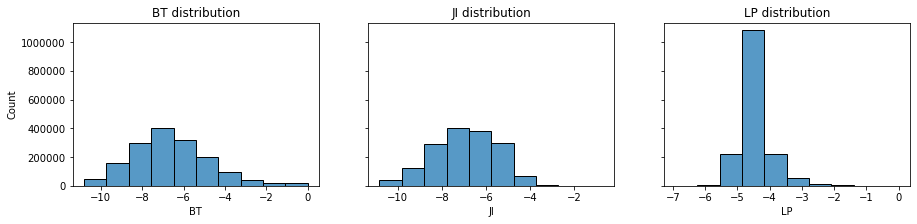

In [24]:
#edges = subsampling_2(100000, 150)
#estimate_probabilities(edges)

fig, ax = plt.subplots(1,3,figsize = (15,3), sharey= True)
sns.histplot(labels.BT.apply(np.log), bins=10, ax = ax[0])
ax[0].set_title("BT distribution")
sns.histplot(labels.JI.apply(np.log), bins=10, ax = ax[1])
ax[1].set_title("JI distribution")
sns.histplot(labels.LP.apply(np.log), bins=10, ax = ax[2])
ax[2].set_title("LP distribution")
plt.show()

end